In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/str-unsupervised-dataset/eng_dev.csv


In [2]:
!pip install tqdm
from tqdm import tqdm
import time
import pickle
import pandas as pd
tqdm.pandas()

In [3]:
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Load the English language model in spaCy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def is_english_word(word):
    return word.isalpha()

word_to_number = {}
number_to_word = {}
next_number = [0]

def get_number_for_word(word):
    if word in word_to_number:
        return word_to_number[word]
    else:
        word_to_number[word] = next_number[0]
        number_to_word[next_number[0]] = word
        next_number[0] += 1
        return word_to_number[word]

In [5]:
random_wikipedia_url = "https://en.wikipedia.org/wiki/Special:Random"
response = requests.get(random_wikipedia_url)

soup = BeautifulSoup(response.content, 'html.parser')
content = soup.find('div', {'class': 'mw-parser-output'})

wikipedia_link = response.url
print("Wikipedia Link:", wikipedia_link)

article_text = content.get_text()

paragraphs = article_text.split('\n')

d1 = [] 
for i, paragraph in enumerate(paragraphs):
    sentences = sent_tokenize(paragraph)

    cleaned_sentences = []
    for sentence in sentences:
        words = word_tokenize(sentence)

        doc = nlp(sentence)
        lemmatized_words = [token.lemma_ for token in doc if not token.is_stop and is_english_word(token.text) and not token.is_title]
        if not lemmatized_words:
            continue
        cleaned_sentence = [get_number_for_word(word) for word in lemmatized_words]
        cleaned_sentences.append(cleaned_sentence)
    
    if cleaned_sentences:
        d1.append(cleaned_sentences)

Wikipedia Link: https://en.wikipedia.org/wiki/Henry_Vane,_2nd_Earl_of_Darlington


In [6]:
d1

[[[0]],
 [[1, 2, 3, 4, 5],
  [6, 7, 1, 8, 4, 9, 10],
  [11, 12, 13, 10, 14, 15, 16, 17, 18, 13, 19, 20]],
 [[21, 22, 23, 24, 25, 26, 27, 28]],
 [[29, 30]],
 [[0]],
 [[31, 32, 33, 34]],
 [[35],
  [36, 37, 38, 39, 40, 39, 38, 41],
  [42, 43, 44, 45, 46, 47],
  [48, 46, 46]],
 [[49], [50]],
 [[51, 52, 47, 53, 54, 55, 56, 57, 6, 58], [59, 60], [45, 31, 61]],
 [[62, 63], [64]],
 [[59, 65]],
 [[66]],
 [[59, 67]],
 [[68]],
 [[69]],
 [[70], [71]],
 [[72], [73]],
 [[74, 75]],
 [[76, 77]],
 [[78, 79]],
 [[76, 80]],
 [[76, 80]],
 [[81]],
 [[82]],
 [[83, 84]],
 [[81]],
 [[85]],
 [[86]],
 [[87]],
 [[88]],
 [[88]],
 [[89]],
 [[90]],
 [[91, 92]],
 [[93]],
 [[94]],
 [[95, 96, 97, 98], [6, 99]],
 [[1, 100, 101, 98], [6, 99]]]

In [7]:
co_occurrence_dict = {}

for para in d1:
    for sentence in para:
        unique_words = set(sentence) 

        unique_words = list(unique_words)  
        for i in range(len(unique_words)):
            for j in range(i + 1, len(unique_words)):
                word_id1 = unique_words[i]
                word_id2 = unique_words[j]
                
                if word_id1 < word_id2:
                    count_x = sentence.count(word_id1)
                    count_y = sentence.count(word_id2)
                    co_occurrence_count = count_x * count_y
                    
                    if (word_id1, word_id2) not in co_occurrence_dict:
                        co_occurrence_dict[(word_id1, word_id2)] = [co_occurrence_count, 0, 0]
                    else:
                        co_occurrence_dict[(word_id1, word_id2)][0] += co_occurrence_count

In [8]:
for para in d1:
    sentences = [sentence for para in para for sentence in para]

    unique_words = set(sentences)
    unique_words = list(unique_words)
    for i in range(len(unique_words)):
        for j in range(i + 1, len(unique_words)):
            word_id1 = unique_words[i]
            word_id2 = unique_words[j]

            if word_id1 < word_id2:
                count_x = sentences.count(word_id1)
                count_y = sentences.count(word_id2)
                co_occurrence_count = count_x * count_y
                if (word_id1, word_id2) not in co_occurrence_dict:
                    co_occurrence_dict[(word_id1, word_id2)] = [0, co_occurrence_count, 0]
                else:
                    co_occurrence_dict[(word_id1, word_id2)][1] += co_occurrence_count

In [9]:
flattened_sentences = [sentence for para in d1 for sentence in para]
flattened_sentences = [word for sentence in flattened_sentences for word in sentence]

unique_words = set(flattened_sentences)
unique_words = list(unique_words)

for i in range(len(unique_words)):
    for j in range(i + 1, len(unique_words)):
        word_id1 = unique_words[i]
        word_id2 = unique_words[j]

        if word_id1 < word_id2:
            count_x = flattened_sentences.count(word_id1)
            count_y = flattened_sentences.count(word_id2)
            co_occurrence_count = count_x * count_y
            if (word_id1, word_id2) not in co_occurrence_dict:
                co_occurrence_dict[(word_id1, word_id2)] = [0, 0, co_occurrence_count]
            else:
                co_occurrence_dict[(word_id1, word_id2)][2] += co_occurrence_count

# print("Co-occurrence Dictionary:")
# for pair, counts in co_occurrence_dict.items():
#     print(pair, "Sentence:", counts[0], "Paragraph:", counts[1], "Document:", counts[2])

In [10]:
co_occurrence_dict_size = len(co_occurrence_dict)
co_occurrence_dict_size

5151

/tmp/ipykernel_32/1263951097.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(first_triplet_values, shade=True, color='b')


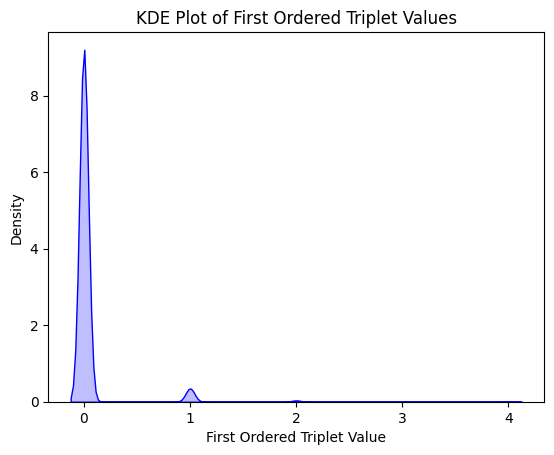

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

first_triplet_values = [entry[0] for entry in co_occurrence_dict.values()]

sns.kdeplot(first_triplet_values, shade=True, color='b')
plt.xlabel("First Ordered Triplet Value")
plt.ylabel("Density")
plt.title("KDE Plot of First Ordered Triplet Values")

plt.show()


/tmp/ipykernel_32/423007460.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(first_triplet_values, shade=True, color='b')


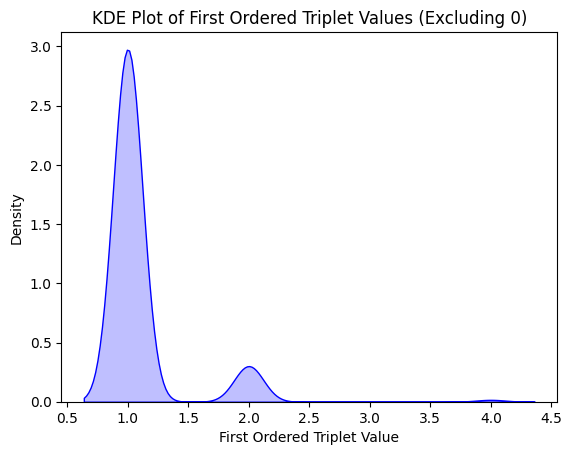

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a list of first ordered triplet values from the co-occurrence dictionary
first_triplet_values = [entry[0] for entry in co_occurrence_dict.values() if entry[0] != 0]

# Create a KDE plot
sns.kdeplot(first_triplet_values, shade=True, color='b')
plt.xlabel("First Ordered Triplet Value")
plt.ylabel("Density")
plt.title("KDE Plot of First Ordered Triplet Values (Excluding 0)")

# Show the KDE plot
plt.show()


# run from here

In [21]:
def is_english_word(word):
    return word.isalpha()

word_to_number = {}
number_to_word = {}
next_number = [0]

def get_number_for_word(word):
    if word in word_to_number:
        return word_to_number[word]
    else:
        word_to_number[word] = next_number[0]
        number_to_word[next_number[0]] = word
        next_number[0] += 1
        return word_to_number[word]
    
co_occurrence_dict = {}

In [22]:
num_words_in_random = []
size_of_dict_random = []
time_takes_random = []

In [70]:
len(num_words_in_random), len(size_of_dict_random), len(time_takes_random)

(600, 600, 600)

In [51]:
with open("/kaggle/working/co_occurrence_dict.pkl", "rb") as file:
    co_occurrence_dict = pickle.load(file)

with open("/kaggle/working/word_to_number.pkl", "rb") as file:
    word_to_number = pickle.load(file)

with open("/kaggle/working/number_to_word.pkl", "rb") as file:
    number_to_word = pickle.load(file)

with open("/kaggle/working/next_number.pkl", "rb") as file:
    next_number = pickle.load(file)

In [52]:
total_time = 0
for iteration in range(100):
    start_time = time.time()
    random_wikipedia_url = "https://en.wikipedia.org/wiki/Special:Random"
    response = requests.get(random_wikipedia_url)

    soup = BeautifulSoup(response.content, 'html.parser')
#     content = soup.find('div', {'class': 'mw-parser-output'})
    content = soup.find('div', {'class': 'mw-body-content mw-content-ltr'})

    wikipedia_link = response.url
    print("Wikipedia Link:", wikipedia_link)

    article_text = content.get_text()

    paragraphs = article_text.split('\n')

    d1 = [] 
    for i, paragraph in enumerate(paragraphs):
        sentences = sent_tokenize(paragraph)

        cleaned_sentences = []
        for sentence in sentences:
            sentence = sentence.lower()
            words = word_tokenize(sentence)

            doc = nlp(sentence)
            lemmatized_words = [token.lemma_ for token in doc if not token.is_stop and is_english_word(token.text) and not token.is_title]
            if not lemmatized_words:
                continue
            cleaned_sentence = [get_number_for_word(word) for word in lemmatized_words]
            cleaned_sentences.append(cleaned_sentence)

        if cleaned_sentences:
            d1.append(cleaned_sentences)

    for para in d1:
        for sentence in para:
            unique_words = set(sentence) 

            unique_words = list(unique_words)  
            for i in range(len(unique_words)):
                for j in range(i + 1, len(unique_words)):
                    word_id1 = unique_words[i]
                    word_id2 = unique_words[j]
                
                    if word_id1 > word_id2:
                        temp = word_id1
                        word_id1 = word_id2
                        word_id2 = temp
                    count_x = sentence.count(word_id1)
                    count_y = sentence.count(word_id2)
                    co_occurrence_count = count_x * count_y

                    if (word_id1, word_id2) not in co_occurrence_dict:
                        co_occurrence_dict[(word_id1, word_id2)] = [co_occurrence_count, 0, 0]
                    else:
                        co_occurrence_dict[(word_id1, word_id2)][0] += co_occurrence_count


    for para in d1:
        sentences = [sentence for para in para for sentence in para]

        unique_words = set(sentences)
        unique_words = list(unique_words)
        for i in range(len(unique_words)):
            for j in range(i + 1, len(unique_words)):
                word_id1 = unique_words[i]
                word_id2 = unique_words[j]

                if word_id1 > word_id2:
                    temp = word_id1
                    word_id1 = word_id2
                    word_id2 = temp
                count_x = sentences.count(word_id1)
                count_y = sentences.count(word_id2)
                co_occurrence_count = count_x * count_y
                if (word_id1, word_id2) not in co_occurrence_dict:
                    co_occurrence_dict[(word_id1, word_id2)] = [0, co_occurrence_count, 0]
                else:
                    co_occurrence_dict[(word_id1, word_id2)][1] += co_occurrence_count


    flattened_sentences = [sentence for para in d1 for sentence in para]
    flattened_sentences = [word for sentence in flattened_sentences for word in sentence]

    unique_words = set(flattened_sentences)
    unique_words = list(unique_words)

    for i in range(len(unique_words)):
        for j in range(i + 1, len(unique_words)):
            word_id1 = unique_words[i]
            word_id2 = unique_words[j]

            if word_id1 > word_id2:
                temp = word_id1
                word_id1 = word_id2
                word_id2 = temp
            count_x = flattened_sentences.count(word_id1)
            count_y = flattened_sentences.count(word_id2)
            co_occurrence_count = count_x * count_y
            if (word_id1, word_id2) not in co_occurrence_dict:
                co_occurrence_dict[(word_id1, word_id2)] = [0, 0, co_occurrence_count]
            else:
                co_occurrence_dict[(word_id1, word_id2)][2] += co_occurrence_count
    
    print("number of unique words in this : ", len(unique_words))
    co_occurrence_dict_size = len(co_occurrence_dict)
    print("size of co-occurence dictionary : ", co_occurrence_dict_size)
    
    num_words_in_random.append(len(unique_words))
    size_of_dict_random.append(co_occurrence_dict_size)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    total_time += elapsed_time
    print(f"Iteration {iteration + 1}: Time taken = {elapsed_time:.2f} seconds")
    time_takes_random.append(elapsed_time)

total_time_in_seconds = total_time
average_time_per_iteration = total_time / 100  # Assuming 100 iterations
print(f"Total Time Taken: {total_time_in_seconds:.2f} seconds")
print(f"Average Time Taken per Iteration: {average_time_per_iteration:.2f} seconds")

Wikipedia Link: https://en.wikipedia.org/wiki/Tura_(name)
number of unique words in this :  50
size of co-occurence dictionary :  29010218
Iteration 1: Time taken = 0.56 seconds
Wikipedia Link: https://en.wikipedia.org/wiki/2016_FINA_World_Swimming_Championships_(25_m)_%E2%80%93_Men%27s_4_%C3%97_50_metre_medley_relay
number of unique words in this :  227
size of co-occurence dictionary :  29031669
Iteration 2: Time taken = 3.25 seconds
Wikipedia Link: https://en.wikipedia.org/wiki/Tobi_Pelly
number of unique words in this :  41
size of co-occurence dictionary :  29031861
Iteration 3: Time taken = 0.98 seconds
Wikipedia Link: https://en.wikipedia.org/wiki/Marc_Haynes
number of unique words in this :  169
size of co-occurence dictionary :  29037461
Iteration 4: Time taken = 2.29 seconds
Wikipedia Link: https://en.wikipedia.org/wiki/Dace_Reg%C5%BEa
number of unique words in this :  139
size of co-occurence dictionary :  29044710
Iteration 5: Time taken = 1.93 seconds
Wikipedia Link: https

In [54]:
with open("co_occurrence_dict.pkl", "wb") as file:
    pickle.dump(co_occurrence_dict, file)
    
with open("word_to_number.pkl", "wb") as file:
    pickle.dump(word_to_number, file)

with open("number_to_word.pkl", "wb") as file:
    pickle.dump(number_to_word, file)

with open("next_number.pkl", "wb") as file:
    pickle.dump(next_number, file)

# checking words in test file

In [55]:
df = pd.read_csv('/kaggle/input/str-unsupervised-dataset/eng_dev.csv')

df.head()
df['Text'].iloc[0]
df.shape

(5500, 2)

In [56]:
df[['text1', 'text2']] = df['Text'].str.split('\n', expand=True)
df.drop(columns=['Text'], inplace=True)

df.head()

,PairID,text1,text2
0,ENG-train-0000,"It that happens, just pull the plug.","if that ever happens, just pull the plug."
1,ENG-train-0001,A black dog running through water.,A black dog is running through some water.
2,ENG-train-0002,I've been searchingthe entire abbey for you.,I'm looking for you all over the abbey.
3,ENG-train-0003,If he is good looking and has a good personali...,"If he's good looking, and a good personality, ..."
4,ENG-train-0004,"She does not hate you, she is just annoyed wit...","She doesn't hate you, she is just annoyed."


In [57]:
# df['text1_new'] = df['text1'].progress_apply(lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_stop and is_english_word(token.text)]))
# df['text2_new'] = df['text2'].progress_apply(lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_stop and is_english_word(token.text)]))

# df.head()

In [58]:
df['text1_new'] = df['text1'].progress_apply(lambda text: " ".join([token.lemma_ for token in nlp(text.lower()) if not token.is_stop and is_english_word(token.text)]))
df['text2_new'] = df['text2'].progress_apply(lambda text: " ".join([token.lemma_ for token in nlp(text.lower()) if not token.is_stop and is_english_word(token.text)]))

df.head()


100%|██████████| 5500/5500 [00:57<00:00, 96.23it/s] 


,PairID,text1,text2,text1_new,text2_new
0,ENG-train-0000,"It that happens, just pull the plug.","if that ever happens, just pull the plug.",happen pull plug,happen pull plug
1,ENG-train-0001,A black dog running through water.,A black dog is running through some water.,black dog run water,black dog run water
2,ENG-train-0002,I've been searchingthe entire abbey for you.,I'm looking for you all over the abbey.,searchingthe entire abbey,look abbey
3,ENG-train-0003,If he is good looking and has a good personali...,"If he's good looking, and a good personality, ...",good look good personality straight likely bis...,good looking good personality straight likely bi
4,ENG-train-0004,"She does not hate you, she is just annoyed wit...","She doesn't hate you, she is just annoyed.",hate annoyed,hate annoy


In [59]:
print(df['text1'].iloc[4458])
print(df['text2'].iloc[4458])
print(df['text1_new'].iloc[4458])
print(df['text2_new'].iloc[4458])

His aim was to let Holiday tell her story in her own way .
The keepers ' cottages are today let as holiday houses .
aim let holiday tell story way
keeper cottage today let holiday house


In [60]:
unique_word_sets = [set(row['text1_new'].split()) | set(row['text2_new'].split()) for _, row in df.iterrows()]

combined_unique_words = set().union(*unique_word_sets)

words_in_dict = sum(1 for word in combined_unique_words if word in word_to_number)

percentage_in_dict = (words_in_dict / len(combined_unique_words)) * 100

print(f"Percentage of unique words present in 'word_to_number' dictionary: {percentage_in_dict:.2f}%")

Percentage of unique words present in 'word_to_number' dictionary: 65.22%


In [61]:
len(combined_unique_words)

10789

In [62]:
import random

unique_words_not_in_dict = []
for _, row in df.iterrows():
    text1_words = row['text1_new'].split()
    text2_words = row['text2_new'].split()
    unique_words = set(text1_words + text2_words)
    unique_words_not_in_dict.extend([word for word in unique_words if word not in word_to_number])

random_words = random.sample(unique_words_not_in_dict, 200)

print(random_words)


['fuck', 'damakis', 'hopefully', 'heroine', 'cuz', 'sicarius', 'wrap', 'edb', 'scotus', 'koror', 'glance', 'gath', 'digit', 'lampard', 'squirt', 'maira', 'gravitational', 'alot', 'suitcase', 'judr', 'arabdonorgroup', 'queenship', 'spoil', 'avril', 'reproright', 'retelling', 'definitely', 'preppy', 'definitely', 'rapist', 'ghostbuster', 'unicameral', 'symtom', 'disenfranchised', 'suberbia', 'louder', 'vole', 'twenty', 'ophelia', 'leornak', 'fataher', 'sprinkle', 'blurry', 'atticus', 'amusement', 'tolkien', 'talibanisation', 'affirmative', 'leek', 'hillaryclinton', 'caricature', 'deianeira', 'rino', 'danaus', 'ipswich', 'taliban', 'hen', 'tungtu', 'hillaryclinton', 'preternatural', 'robard', 'uptight', 'subordinate', 'ppl', 'karr', 'faced', 'okay', 'doze', 'galderisi', 'alastor', 'unsubscribe', 'renderer', 'obsure', 'womensright', 'wh', 'morphine', 'watergate', 'womensright', 'magdalene', 'dressing', 'whiff', 'idiot', 'ligature', 'resaca', 'pena', 'bicycling', 'landfall', 'snowboard', 'r

In [63]:
total = 0 
bigram_occurs = 0  
word_but_not_pair = 0 
for index, row in df.iterrows():
    words_text1 = set(row['text1_new'].split())
    words_text2 = set(row['text2_new'].split())

    common_words = words_text1 & words_text2

    unique_words_text1 = len(words_text1)
    unique_words_text2 = len(words_text2)

    common_unique_words = len(common_words)
    total += (unique_words_text1 * unique_words_text2)

    for word1 in words_text1:
        if word1 in word_to_number:
            for word2 in words_text2:
                if word2 in word_to_number:
                    num1 = word_to_number[word1]
                    num2 = word_to_number[word2]

                    if num1 > num2:
                        temp = num1
                        num1 = num2
                        num2 = temp
                    if (num1, num2) in co_occurrence_dict:
                        bigram_occurs += 1
                    else:
                        word_but_not_pair += 1

result = {
    'Total': total,
    'Bigram Occurs': bigram_occurs,
    'Words in Text1 but not a Pair': word_but_not_pair,
}

print(result)


{'Total': 196236, 'Bigram Occurs': 105923, 'Words in Text1 but not a Pair': 47517}


In [67]:
bigram_occurs/total*100

53.977353798487535

In [69]:
word_but_not_pair/total*100

24.21421145967101

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(time_takes_random, shade=True)
plt.xlabel('Time Taken (seconds)')
plt.ylabel('Density')
plt.title('KDE Plot of Time Taken')
plt.show()
plt.savefig('time_takes_kde.pdf')
plt.close()

sns.kdeplot(num_words_in_random, shade=True)
plt.xlabel('Number of Unique Words')
plt.ylabel('Density')
plt.title('KDE Plot of Unique Words')
plt.show()
plt.savefig('num_words_kde.pdf')
plt.close()

iterations = list(range(1, len(size_of_dict_random) + 1))
plt.plot(iterations, size_of_dict_random)
plt.xlabel('Number of Iterations')
plt.ylabel('Size of Co-occurrence Dictionary')
plt.title('Time Series Plot of Dictionary Size')
plt.show()
plt.savefig('dictionary_size_timeseries.pdf')
plt.close()


NameError: name 'time_takes_random' is not defined

In [218]:
import multiprocessing

In [219]:
def is_english_word(word):
    return word.isalpha()

word_to_number = {}
number_to_word = {}
next_number = [0]

def get_number_for_word(word):
    if word in word_to_number:
        return word_to_number[word]
    else:
        word_to_number[word] = next_number[0]
        number_to_word[next_number[0]] = word
        next_number[0] += 1
        return word_to_number[word]
    
co_occurrence_dict = {}

In [220]:
import time
import requests
from bs4 import BeautifulSoup
from multiprocessing import Pool

its = []

def process_iteration(iteration, co_occurrence_dict):
    random_wikipedia_url = "https://en.wikipedia.org/wiki/Special:Random"
    response = requests.get(random_wikipedia_url)

    soup = BeautifulSoup(response.content, 'html.parser')
#     content = soup.find('div', {'class': 'mw-parser-output'})
    content = soup.find('div', {'class': 'mw-body-content mw-content-ltr'})

    wikipedia_link = response.url
#     print("Wikipedia Link:", wikipedia_link)

    article_text = content.get_text()

    paragraphs = article_text.split('\n')

    d1 = [] 
    for i, paragraph in enumerate(paragraphs):
        sentences = sent_tokenize(paragraph)

        cleaned_sentences = []
        for sentence in sentences:
            sentence = sentence.lower()
            words = word_tokenize(sentence)

            doc = nlp(sentence)
            lemmatized_words = [token.lemma_ for token in doc if not token.is_stop and is_english_word(token.text) and not token.is_title]
            if not lemmatized_words:
                continue
            cleaned_sentence = [get_number_for_word(word) for word in lemmatized_words]
            cleaned_sentences.append(cleaned_sentence)

        if cleaned_sentences:
            d1.append(cleaned_sentences)

    for para in d1:
        for sentence in para:
            unique_words = set(sentence) 

            unique_words = list(unique_words)  
            for i in range(len(unique_words)):
                for j in range(i + 1, len(unique_words)):
                    word_id1 = unique_words[i]
                    word_id2 = unique_words[j]
                
                    if word_id1 > word_id2:
                        temp = word_id1
                        word_id1 = word_id2
                        word_id2 = temp
                    count_x = sentence.count(word_id1)
                    count_y = sentence.count(word_id2)
                    co_occurrence_count = count_x * count_y

                    if (word_id1, word_id2) not in co_occurrence_dict:
                        co_occurrence_dict[(word_id1, word_id2)] = [co_occurrence_count, 0, 0]
                    else:
                        co_occurrence_dict[(word_id1, word_id2)][0] += co_occurrence_count


    for para in d1:
        sentences = [sentence for para in para for sentence in para]

        unique_words = set(sentences)
        unique_words = list(unique_words)
        for i in range(len(unique_words)):
            for j in range(i + 1, len(unique_words)):
                word_id1 = unique_words[i]
                word_id2 = unique_words[j]

                if word_id1 > word_id2:
                    temp = word_id1
                    word_id1 = word_id2
                    word_id2 = temp
                count_x = sentences.count(word_id1)
                count_y = sentences.count(word_id2)
                co_occurrence_count = count_x * count_y
                if (word_id1, word_id2) not in co_occurrence_dict:
                    co_occurrence_dict[(word_id1, word_id2)] = [0, co_occurrence_count, 0]
                else:
                    co_occurrence_dict[(word_id1, word_id2)][1] += co_occurrence_count


    flattened_sentences = [sentence for para in d1 for sentence in para]
    flattened_sentences = [word for sentence in flattened_sentences for word in sentence]

    unique_words = set(flattened_sentences)
    unique_words = list(unique_words)

    for i in range(len(unique_words)):
        for j in range(i + 1, len(unique_words)):
            word_id1 = unique_words[i]
            word_id2 = unique_words[j]

            if word_id1 > word_id2:
                temp = word_id1
                word_id1 = word_id2
                word_id2 = temp
            count_x = flattened_sentences.count(word_id1)
            count_y = flattened_sentences.count(word_id2)
            co_occurrence_count = count_x * count_y
            if (word_id1, word_id2) not in co_occurrence_dict:
                co_occurrence_dict[(word_id1, word_id2)] = [0, 0, co_occurrence_count]
            else:
                co_occurrence_dict[(word_id1, word_id2)][2] += co_occurrence_count
    
    print("number of unique words in this : ", len(unique_words))
    co_occurrence_dict_size = len(co_occurrence_dict)
    print("size of co-occurence dictionary : ", co_occurrence_dict_size)    
#     print(f"Iteration {iteration + 1} completed.")
    its.append(1);
    print("done : ", len(its))

In [ ]:
num_iterations = 100

with multiprocessing.Manager() as manager:
    co_occurrence_dict = manager.dict()

    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = [pool.apply_async(process_iteration, (i, co_occurrence_dict)) for i in range(num_iterations)]
        for result in results:
            result.get()

number of unique words in this :  36
size of co-occurence dictionary :  1171
done :  1
number of unique words in this :  97
size of co-occurence dictionary :  8373
done :  1
number of unique words in this :  124
size of co-occurence dictionary :  14566
done :  1
number of unique words in this :  82
size of co-occurence dictionary :  25337
done :  2
number of unique words in this :  175
size of co-occurence dictionary :  32152
done :  1
number of unique words in this :  178
size of co-occurence dictionary :  40205
done :  2
number of unique words in this :  203
size of co-occurence dictionary :  73111
done :  3
number of unique words in this :  139
size of co-occurence dictionary :  74242
done :  3
number of unique words in this :  102
size of co-occurence dictionary :  86346
done :  4
number of unique words in this :  68
size of co-occurence dictionary :  94582
done :  5
number of unique words in this :  52
size of co-occurence dictionary :  100076
done :  6
number of unique words in t